In [1]:
from src.eda_vector import *
from src.lda_model import *
from src.model import *
from src.classifier import *

In [2]:
'''
NOTE: No EDA appears in this notebook. See Untitled-Copy2 for EDA
--> EDA methods also availible in EDA_vec class
'''

'\nNOTE: No EDA appears in this notebook. See Untitled-Copy2 for EDA\n--> EDA methods also availible in EDA_vec class\n'

In [23]:
# train, test, split
X_train, X_test, y_train, y_test = get_data(num_samples=750000)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [24]:
# vectorizing process
custom_stops = ['https', 'rt', 'co', 'amp', 'via', 'go', 'get', 'said', 'say', 'news', 'new', 'make', 'want', 
                'trump', 'clinton', 'donald', 'donald trump', 'donaldtrump', 'says', 'hillary', 'hillaryclinton',
                'hillary clinton', 'realdonaldtrump', 'would', 'let', 'video', 'like']

# fit vectorizer, add stop words, return vocab
vectors = EDA_vec(X_train, y_train)
vectors.add_stop_words(custom_stops)
vocab, fit_mat = vectors.vectorize(min_df=0.0001)

# transform traininng and testing data 
matrix = fit_mat.transform(X_train)
matrix_test = fit_mat.transform(X_test)

In [25]:
matrix.shape, matrix_test.shape

((375000, 14275), (125000, 14275))

In [26]:
# fit LDA model on training data
lda = LDA_model(topics=5)
lda.fit(matrix, y_train, vocab)
lda.phi() # to evaluate coherence score
theta = lda.theta()

# get test theta for random forest evaluation
theta_test = lda.test_theta(matrix_test)

In [27]:
# random forest 
forest = RandForest(n_estimators=100, max_depth=50, max_leaf=50, max_features=theta.shape[1])
forest.fit(theta, y_train)
probas, y_hat = forest.predict(theta_test)
forest.score(y_test, y_hat)

In [28]:
print(f'accuracy = {forest.acc}')
print(f'oob = {forest.oob}')
print(f'recall = {forest.recall}')
print(f'precision = {forest.precision}')

accuracy = 0.92
oob = 0.92
recall = 1.0
precision = 0.92


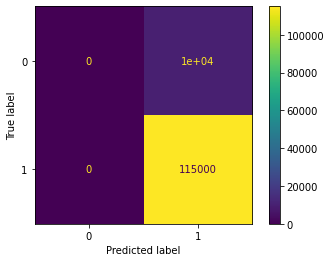

In [29]:
forest.plot_confusion()

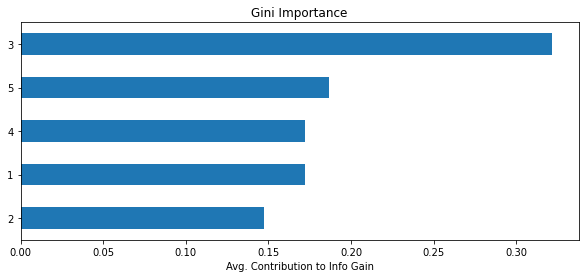

In [30]:
forest.chart_gini_import()

In [31]:
lda.coherance_score()

-4.748669717009582

In [ ]:
'''TOPIC COHERANCE SCORES: --> only 10k data samples'''
# topics 2 --> -7.487219089117191
# topics 4 --> -10.222697013007569
# topics 6 --> -12.070494413320219
# topics 8 --> -13.165411752758045
# topics 10 --> -13.466351137344793
# topics 12 --> -14.279565234962526
# topics 14 --> -14.610241988703596
# topics 18 --> -15.333867297657738
# topics 20 --> -15.802765426002347
# topics 22 --> -15.90626134524627
# topics 24 --> -16.21720655745143
# topics 26 --> -15.494214848919107

In [32]:
# test for best num_topics:

def test_topics(X, y, vocab, low, high, by):
    scores = []
    
    for n_topic in range(low, high, by):
        lda = LDA_model(topics=n_topic)
        lda.fit(X, y, vocab)
        lda.phi()
        score = lda.coherance_score()
        scores.append((n_topic, score))
        
    return scores

def print_topic_score(scores):
    for score in scores:
        print(f'#{score[0]} --> {score[1]}')
        
def plot_topic_scores(scores):
    fig, ax = plt.subplots()
    x = [n_topics[0] for n_topics in scores]
    y = [score[1] for score in scores]
    
    ax.plot(x, y)
    ax.set_title('Coherence Score by Topic')
    ax.set_xlabel('# of Topics')
    ax.set_ylabel('Coherence Score');

In [ ]:
topic_scores = test_topics(matrix, y_train, vocab, 2, 30, 2)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score, precision_score, plot_confusion_matrix

# Random Forest, X = theta, y = y_train
def eval_random_forest(X, y, folds=10, n_estimators=100, max_depth=5, max_leaf=None):
    kf = KFold(n_splits=folds, shuffle=True)
    accuracy = []
    oob = []
    iters = 0
    
    for train, test in kf.split(X):
        
        forest = RandForest(n_estimators=n_estimators, max_depth=max_depth, max_leaf=max_leaf, 
                            max_features=theta.shape[1])
        forest.fit(X.iloc[train], y.iloc[train])
        accuracy.append(forest.score(X.iloc[test], y.iloc[test]))
        oob.append(forest.oob_score_)
        
        print(iters)
        iters += 1
    
    return np.mean(accuracy), np.mean(oob), forest

In [ ]:
'''
1. Balance models
2. Get bettter coherance scores
3. Evaluate best number of estimators, leafs, and max_depth
'''